## 6. Regularyzacja w modelach liniowych

In [47]:
library(yaml)
library(ggplot2)
library(glmnet)
library(knitr)
library(reshape2)

# Global options
options(repr.plot.width = 10, repr.plot.height = 10)

### 6.1 Wczytywanie konfiguracji (*config.yaml*):

In [2]:
config <- yaml.load_file("../config.yaml")

train_filepath <- file.path("..", config$paths$data_train)
test_filepath <- file.path("..", config$paths$data_test)

### 6.2 Przygotowanie danych

Na potrzeby tego zadania, wyodrębniamy ze wczytanego zbioru macierz zmiennych niezależnych (```X```) oraz wartości zmiennej docelowej: ```y```. Reszta pozostaje niezmienna z poprzednimi sekcjami raportu.

In [3]:
data_train <- read.csv(train_filepath)
data_test <- read.csv(test_filepath)

data_train$name <- NULL
data_train$games <- NULL

data_test$name <- NULL
data_test$games <- NULL

# Convert to [X, y] form
X_train <- model.matrix(elo ~ ., data = data_train)[, -1]
y_train <- data_train$elo

X_test <- model.matrix(elo ~ ., data = data_test)[, -1]
y_test <- data_test$elo

### 6.3 Regresja grzbietowa

**Regresja grzbietowa** (ang. ridge regression) to odmiana regresji liniowej, która wprowadza karę za dużą wartość współczynników regresji, aby zapobiec przeuczeniu (overfittingowi), zwłaszcza gdy mamy do czynienia z kolinearnością lub dużą liczbą cech.

Równanie regresji grzbietowej przyjmuje postać:
$$\hat{\mathbf{w}} = \arg\min_{\mathbf{w}} \left\{ \| \mathbf{y} - X\mathbf{w} \|^2 + \lambda \| \mathbf{w} \|^2 \right\}$$
gdzie $\lambda$ (lambda) to hiperparametr regularyzacji, który kontroluje siłę kary za duże wartości wag (Jeśli $\lambda = 0$, mamy zwykłą regresję liniową).

In [40]:
lambda_grid <- 10^seq(10, -2, length.out = 100)

fit_ridge <- glmnet(X_train, y_train, alpha = 0, lambda = lambda_grid)

In [41]:
cat(sprintf("Wybrana wartość lambda (dla indeksu 50): %.6f\n\n", fit_ridge$lambda[50]))

coef_ridge <- coef(fit_ridge)[, 50]

cat("Współczynniki regresji grzbietowej:")
kable(as.matrix(coef_ridge), col.names = "Wartość")

norma_l2 <- sqrt(sum(coef_ridge[-1]^2))
cat(sprintf("Norma L2 wektora współczynników (bez wyrazu wolnego): %.6f\n", norma_l2))

Wybrana wartość lambda (dla indeksu 50): 11497.569954

Współczynniki regresji grzbietowej:



|                   |      Wartość|
|:------------------|------------:|
|(Intercept)        | 1590.0803649|
|avg_moves          |    0.7618844|
|frac_nonterm       |   30.4786018|
|avg_cp_loss        |   -0.3613145|
|avg_inacc          |   -1.8486750|
|avg_mist           |   -4.2736355|
|avg_blund          |   -9.6182720|
|frac_time_win      |    8.7914131|
|frac_time_loss     |    9.3573553|
|avg_time_good      |   -0.0720027|
|avg_time_inaccm    |    0.2208559|
|avg_time_blund     |    0.1938309|
|avg_mat_imb_per_mv |   -4.0867053|
|avg_book_moves     |    6.4157445|

Norma L2 wektora współczynników (bez wyrazu wolnego): 35.590061


Widzimy, iż współczynniki regresji grzbietowej dla wysokich wartości $\lambda$ są wyraźnie niższe, niż analogiczne współczynniki modelu regresji liniowej bez regularyzacji - mówimy tu o różnicy rzędu kilku do kilkunastu razy mniejszych wartości.

Teraz porównujemy wartości współczynników dla niższej wartości hiperparametru $\lambda$:

In [42]:
cat(sprintf("Wybrana wartość lambda (dla indeksu 70): %.6f\n", fit_ridge$lambda[70]))

coef_ridge <- coef(fit_ridge)[, 70]

cat("Współczynniki regresji grzbietowej:\n")
kable(as.matrix(coef_ridge), col.names = "Wartość")

norma_l2 <- sqrt(sum(coef_ridge[-1]^2))
cat(sprintf("Norma L2 wektora współczynników (bez wyrazu wolnego): %.6f\n", norma_l2))

Wybrana wartość lambda (dla indeksu 70): 43.287613
Współczynniki regresji grzbietowej:




|                   |      Wartość|
|:------------------|------------:|
|(Intercept)        | 1764.0906898|
|avg_moves          |   14.8317431|
|frac_nonterm       |   55.1551151|
|avg_cp_loss        |   -4.4915220|
|avg_inacc          |  -11.9320288|
|avg_mist           |    8.7318931|
|avg_blund          | -111.0278219|
|frac_time_win      |    1.1889489|
|frac_time_loss     |  100.0114222|
|avg_time_good      |  -11.1361744|
|avg_time_inaccm    |    0.0185188|
|avg_time_blund     |    1.5628371|
|avg_mat_imb_per_mv |  -64.0328877|
|avg_book_moves     |   52.2208257|

Norma L2 wektora współczynników (bez wyrazu wolnego): 181.067441


Porównując dwa zestawy wyników regresji grzbietowej dla różnych wartości parametru lambda, można zauważyć istotne różnice w skali współczynników. Dla większej wartości $\lambda$ (11497.57, indeks 50), współczynniki regresji są znacznie bardziej „ściągnięte” w kierunku zera – ich wartości są umiarkowane, a norma L2 wektora wag wynosi jedynie około 35.6. Oznacza to, że model jest silnie regularizowany, co może chronić go przed przeuczeniem, ale jednocześnie może powodować niedouczenie (underfitting), ograniczając jego zdolność do uchwycenia bardziej złożonych zależności w danych.

Z kolei przy mniejszej wartości $\lambda$ (43.29, indeks 70), współczynniki są znacznie większe i bardziej zróżnicowane – na przykład ```avg_blund``` osiąga wartość -111, a ```frac_time_loss``` sięga 100. Norma L2 wzrasta aż do 181.07, co świadczy o znacznie słabszym ograniczaniu wag. Taki model lepiej dopasowuje się do danych treningowych, ale rośnie ryzyko przeuczenia, zwłaszcza w obecności współliniowych cech lub szumu w danych.

Wykorzystamy teraz wczytany zbiór testowy do wyestymowania MSE. Porównujemy przy tym wartości błędu dla różnej siły regularyzacji definiowanej hiperparametrem $\lambda$:

In [43]:
fit_ridge <- glmnet(X_train, y_train, alpha = 0, lambda = lambda_grid, thresh = 1e-12)

pred_null <- mean(y_train)
mse_null <- mean((pred_null - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla modelu zerowego (średnia z y_train): %.4f\n", mse_null))

pred_ridge_0 <- predict(fit_ridge, x = X_train, y = y_train, s = 0, newx = X_test, exact = TRUE)
mse_basic <- mean((pred_ridge_0 - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla regresji liniowej: %.4f\n", mse_basic))

pred_ridge <- predict(fit_ridge, s = 4, newx = X_test)
mse_ridge <- mean((pred_ridge - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla regresji grzbietowej (lambda = 4): %.4f\n", mse_ridge))

pred_ridge_big <- predict(fit_ridge, s = 1e10, newx = X_test)
mse_ridge_big <- mean((pred_ridge_big - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla regresji grzbietowej (lambda = 1e10): %.4f\n", mse_ridge_big))

Błąd średniokwadratowy dla modelu zerowego (średnia z y_train): 163071.1175
Błąd średniokwadratowy dla regresji liniowej: 42569.9625
Błąd średniokwadratowy dla regresji grzbietowej (lambda = 4): 42610.9893
Błąd średniokwadratowy dla regresji grzbietowej (lambda = 1e10): 163071.0913


Powyższe wyniki prowadzą do następujących wniosków:

- Model zerowy osiąga bardzo wysoki błąd średniokwadratowy (MSE) na poziomie $163071.12$, co wskazuje, że nie wykorzystuje żadnej informacji zawartej w cechach predykcyjnych.
- Regresja liniowa znacznie poprawia dokładność predykcji — błąd spada do $42569.96$, co świadczy o tym, że model skutecznie uchwycił istotne zależności w danych.
- Regresja grzbietowa z $\lambda = 4$ nie wpływa znacząco na zdolność modelu do predykcji na nowych danych, co świadczy o tym, że pierwotny model regresji liniowej nie ma problemu z przeuczeniem.
- Regresja grzbietowa z bardzo dużym $\lambda = 10^{10}$ praktycznie zbiega do modelu zerowego — MSE wynosi $163071.09$, czyli prawie identycznie jak w modelu stałym. Oznacza to, że silna regularyzacja niemal całkowicie „zniwelowała” wpływ cech (wszystkie współczynniki są bliskie zeru) i praktycznie wyeliminowała zdolność modelu do uczenia się z danych.

**Walidacja krzyżowa** (ang. cross-validation) pomaga w doborze hiperparametrów, takich jak np. wartość $\lambda$ w regresji grzbietowej, poprzez ocenę modelu na wielu podziałach danych treningowych. W tym przypadku wykorzystamy walidację krzyżową do estymacji optymalnego poziomu regularyzacji:

Optymalna wartość lambda (lambda.min) wybrana przez walidację krzyżową: 29.931292


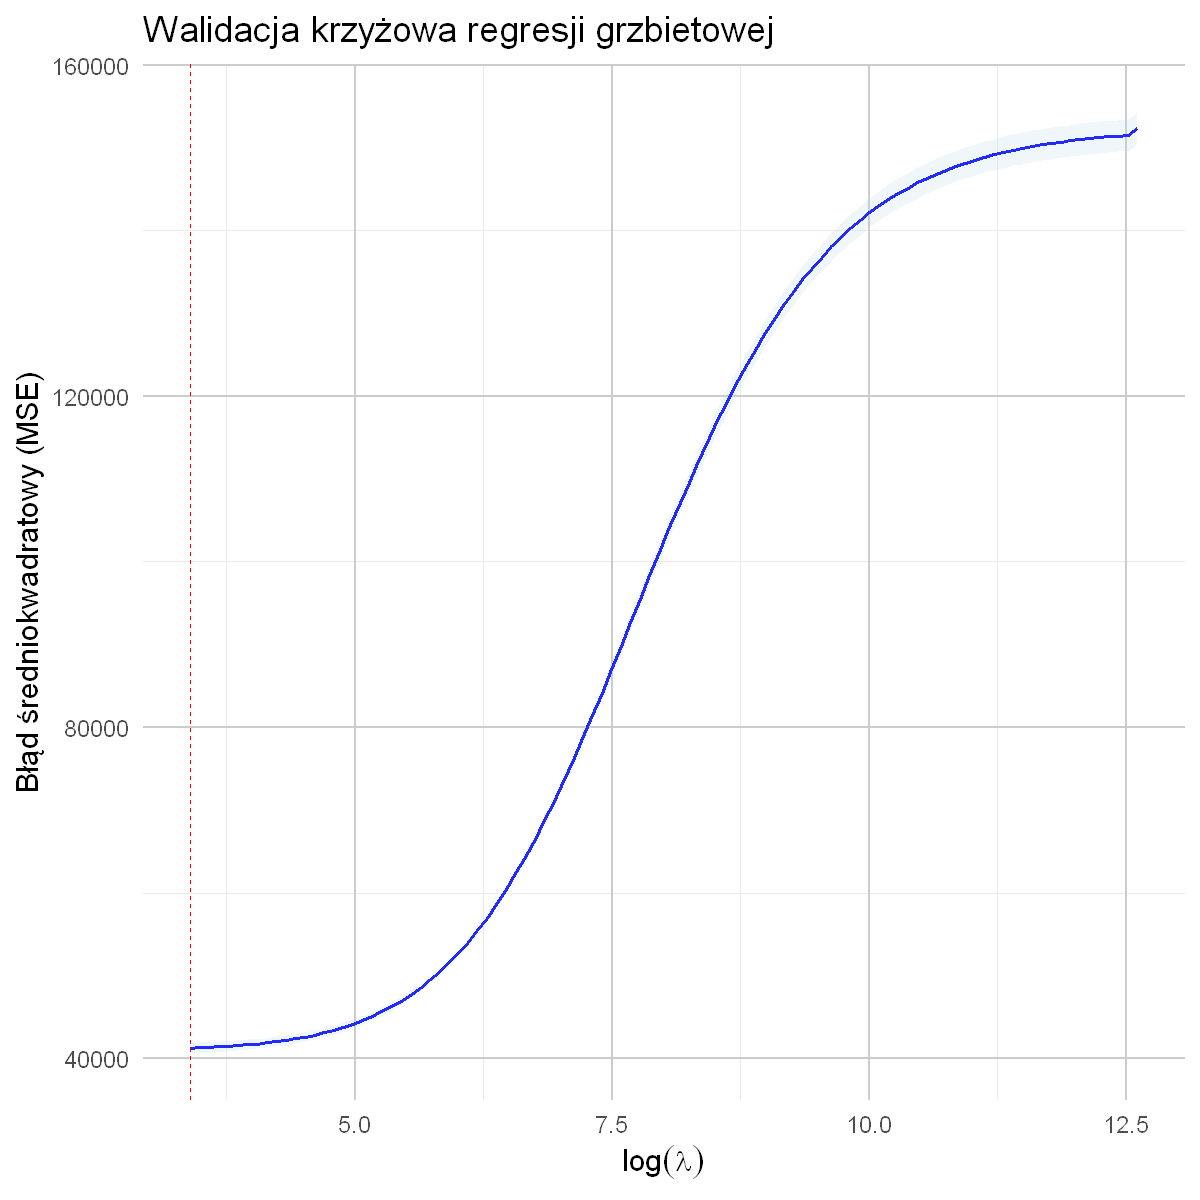

In [44]:
set.seed(410375)

cv_out <- cv.glmnet(X_train, y_train, alpha = 0)

df <- data.frame(
  log_lambda = log(cv_out$lambda),
  cvm = cv_out$cvm,
  cvup = cv_out$cvup,
  cvlo = cv_out$cvlo
)

ggplot(df, aes(x = log_lambda, y = cvm)) +
  geom_line(color = "blue", size = 1) +
  geom_ribbon(aes(ymin = cvlo, ymax = cvup), alpha = 0.2, fill = "lightblue") +
  geom_vline(xintercept = log(cv_out$lambda.min), linetype = "dashed", color = "red") +
  labs(title = "Walidacja krzyżowa regresji grzbietowej",
       x = expression(log(lambda)),
       y = "Błąd średniokwadratowy (MSE)") +
  theme_minimal(base_size = 18) +
  theme(panel.grid.major = element_line(color = "gray80"))

cat(sprintf("Optymalna wartość lambda (lambda.min) wybrana przez walidację krzyżową: %.6f\n", cv_out$lambda.min))

Zgodnie z wykresem, zwiększanie siły regularyzacji w tym konkretnym przypadku prowadzi do pogorszenia zdolności predykcyjnych modelu regresji. 

In [45]:
pred_ridge_opt <- predict(fit_ridge, s = cv_out$lambda.min, newx = X_test)
mse_opt <- mean((pred_ridge_opt - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla regresji grzbietowej z optymalną lambda (%.6f): %.4f\n\n", cv_out$lambda.min, mse_opt))

fit_ridge_full <- glmnet(X_train, y_train, alpha = 0)
coef_opt <- predict(fit_ridge_full, s = cv_out$lambda.min, type = "coefficients")

cat("Współczynniki regresji grzbietowej dla optymalnej lambda:\n")
print(coef_opt)


Błąd średniokwadratowy dla regresji grzbietowej z optymalną lambda (29.931292): 43072.8091

Współczynniki regresji grzbietowej dla optymalnej lambda:
14 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)        1788.1405738
avg_moves            15.2187058
frac_nonterm         35.8564160
avg_cp_loss          -4.5888317
avg_inacc           -13.3557740
avg_mist             11.1974414
avg_blund          -113.6978473
frac_time_win        -5.1875636
frac_time_loss      101.5686581
avg_time_good       -11.6279611
avg_time_inaccm       0.1762163
avg_time_blund        1.6992510
avg_mat_imb_per_mv  -66.4269657
avg_book_moves       51.5686007


Powyższe wyniki pokazują, że regresja grzbietowa z optymalnie dobraną wartością $\lambda \approx 29.93$ osiąga na zbiorze testowym błąd średniokwadratowy około $43072.81$, co wskazuje na dobrą jakość dopasowania modelu. Ponownie jednak jest to więcej niż dla zwykłego modelu regresji liniowej bez regularyzacji, co pokazuje brak potrzeby regularyzowania modelu w tym przypadku.

### 6.4 Lasso

**Regresja Lasso** (ang. Least Absolute Shrinkage and Selection Operator) to odmiana regresji liniowej, która wprowadza karę za sumę wartości bezwzględnych współczynników regresji. W przeciwieństwie do regresji grzbietowej (Ridge), która stosuje karę opartą na sumie kwadratów współczynników, Lasso może wymuszać dokładne zerowanie nieistotnych współczynników, co prowadzi do automatycznej selekcji cech.

Równanie regresji Lasso przyjmuje postać:
$$\hat{\mathbf{w}} = \arg\min_{\mathbf{w}} \left\{ \| \mathbf{y} - X\mathbf{w} \|^2 + \lambda \sum_{j=1}^p |w_j| \right\}$$

gdzie $\lambda$ (lambda) to hiperparametr regularyzacji, który kontroluje siłę kary za wartości wag (jeśli $\lambda = 0$, mamy zwykłą regresję liniową).

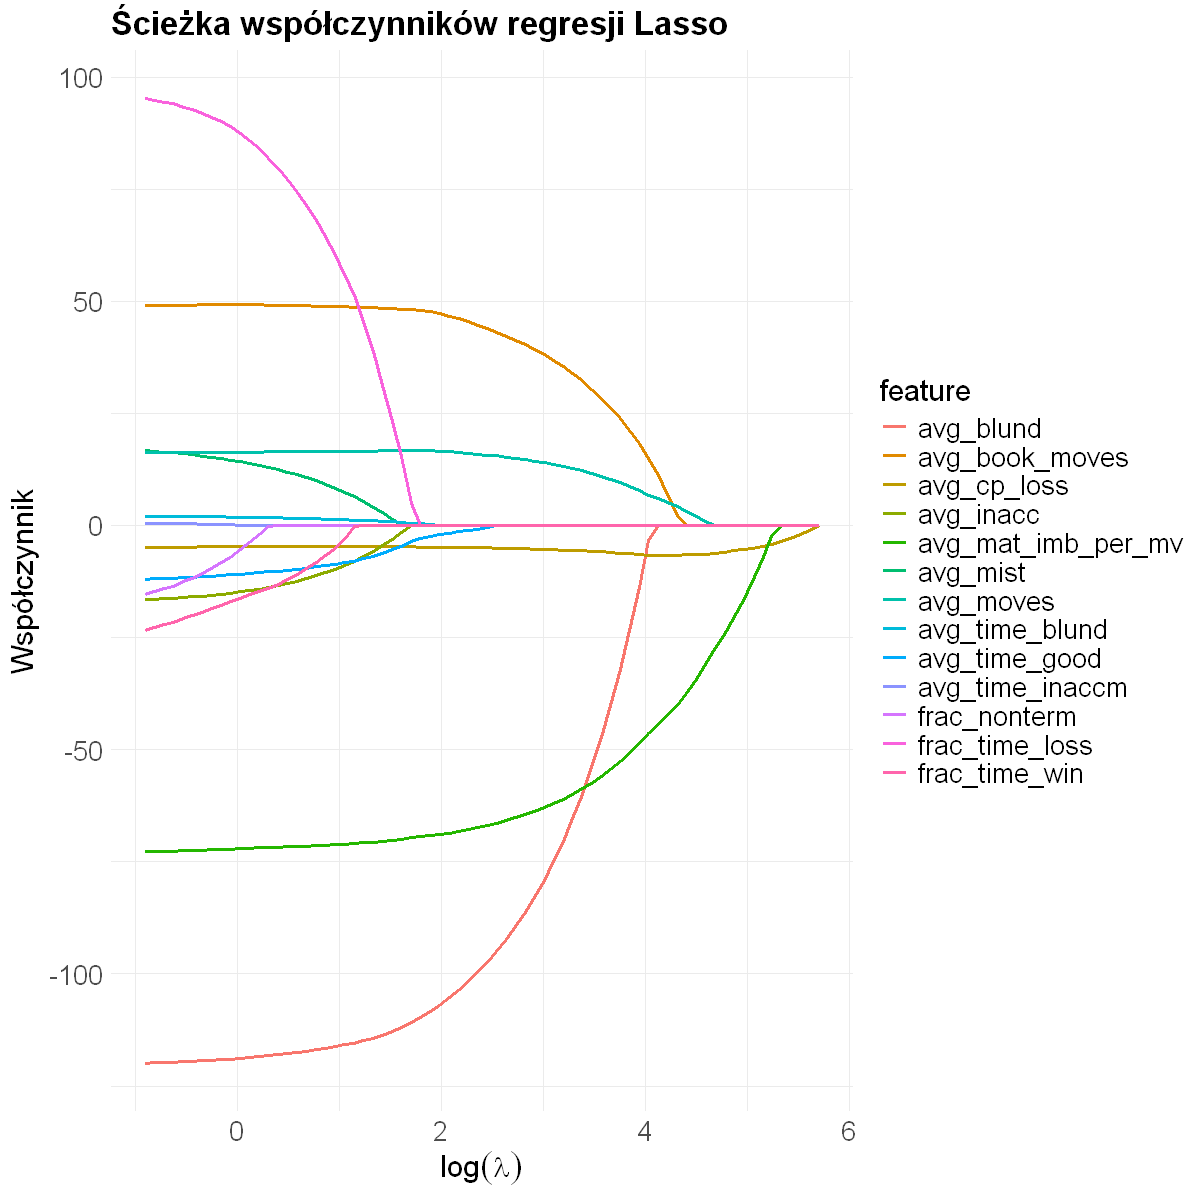

In [50]:
fit_lasso <- glmnet(X_train, y_train, alpha = 1)

coefs <- as.matrix(fit_lasso$beta)
log_lambda <- log(fit_lasso$lambda)

df <- data.frame(log_lambda = rep(log_lambda, each = nrow(coefs)),
                 feature = rep(rownames(coefs), times = ncol(coefs)),
                 coefficient = as.vector(coefs))

ggplot(df, aes(x = log_lambda, y = coefficient, color = feature)) +
  geom_line(size = 1) +
  labs(title = "Ścieżka współczynników regresji Lasso",
       x = expression(log(lambda)),
       y = "Współczynnik") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 16),
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    legend.position = "right"
  )

Widzimy, iż regresja typu Lasso prowadzi do silniejszej selekcji cech - współczynniki związane z mniej istotnymi cechami bardzo szybko sprowadzane są w pobliże zera wraz ze wzrostem wartości hiperparametru $\lambda$. Już dla wartości $\lambda \approx e^6$ wszystkie współczynniki są niemal zerowe, co pokazuje większą siłę regularyzacji względem regresji grzbietowej na tym przykładzie.

Analogicznie jak dla regresji grzbietowej, wykorzystujemy walidację krzyżową do estymacji optymalnej wartości hiperparametru $\lambda$:

Optymalna lambda (lambda.min): 0.404985
Błąd średniokwadratowy dla modelu Lasso z optymalną lambda: 42599.7348


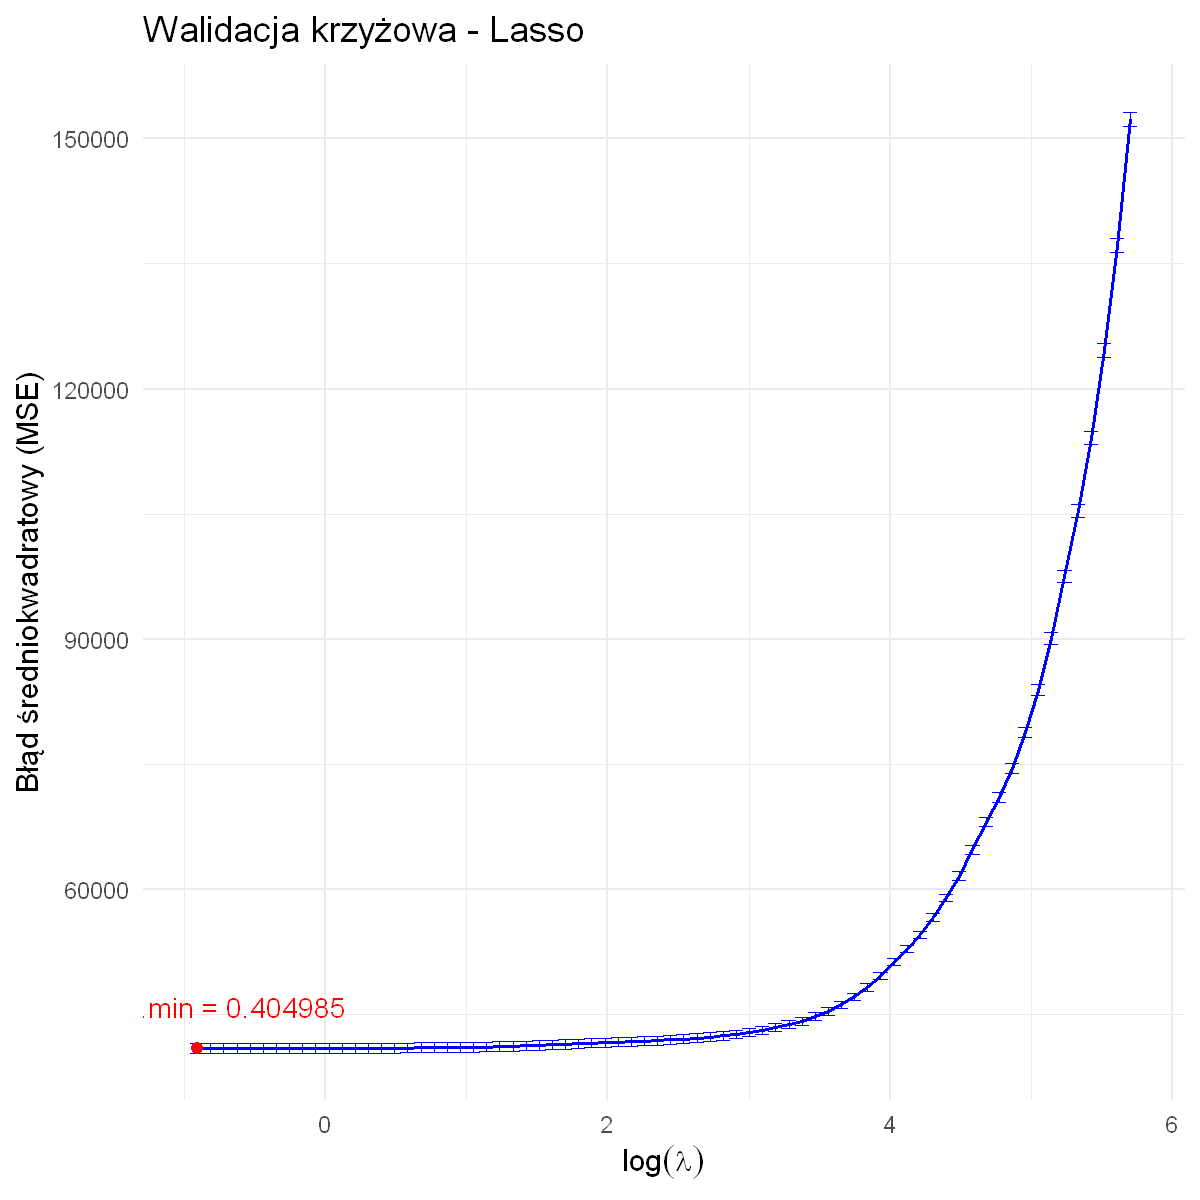

In [60]:
cv_out <- cv.glmnet(X_train, y_train, alpha = 1)

df_cv <- data.frame(
  log_lambda = log(cv_out$lambda),
  cvm = cv_out$cvm,
  cvsd = cv_out$cvsd
)

min_lambda_idx <- which.min(df_cv$cvm)
min_log_lambda <- df_cv$log_lambda[min_lambda_idx]
min_cvm <- df_cv$cvm[min_lambda_idx]

ggplot(df_cv, aes(x = log_lambda, y = cvm)) +
  geom_line(color = "blue", size = 1) +
  geom_errorbar(aes(ymin = cvm - cvsd, ymax = cvm + cvsd), width = 0.1, color = "blue") +
  annotate("point", x = min_log_lambda, y = min_cvm, color = "red", size = 3) +
  annotate("text", x = min_log_lambda, y = min_cvm, 
           label = paste0("lambda.min = ", round(exp(min_log_lambda), 6)), 
           vjust = -1.5, color = "red", size = 6) +
  labs(title = "Walidacja krzyżowa - Lasso",
       x = expression(log(lambda)),
       y = "Błąd średniokwadratowy (MSE)") +
  theme_minimal(base_size = 18)

cat(sprintf("Optymalna lambda (lambda.min): %.6f\n", cv_out$lambda.min))

pred_lasso <- predict(fit_lasso, s = cv_out$lambda.min, newx = X_test)
mse_lasso <- mean((pred_lasso - y_test)^2)
cat(sprintf("Błąd średniokwadratowy dla modelu Lasso z optymalną lambda: %.4f\n", mse_lasso))

Podobnie jak dla regresji grzbietowej, preferowany jest jak najmniejszy poziom regularyzacji.

In [69]:
fit_lasso_full <- glmnet(X_train, y_train, alpha = 1)

predict(fit_lasso_full, s = cv_out$lambda.min, type = "coefficients")

14 x 1 sparse Matrix of class "dgCMatrix"
                             s1
(Intercept)        1846.8304197
avg_moves            16.3347495
frac_nonterm        -15.3659529
avg_cp_loss          -4.8185293
avg_inacc           -16.6113488
avg_mist             16.7089067
avg_blund          -119.9225662
frac_time_win       -23.4287265
frac_time_loss       95.1451312
avg_time_good       -11.9749552
avg_time_inaccm       0.5145419
avg_time_blund        2.0228279
avg_mat_imb_per_mv  -72.7007665
avg_book_moves       49.1162935